# Mini-project 1: Tic-Tac-Toe
Clément DAUVILLIERS - Florian VINCENT

## Imports

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from tqdm.notebook import trange
from typing import List, Tuple, NewType, Union, Callable
from tic_env import TictactoeEnv, OptimalPlayer
from player import Player
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize

In [2]:
import torch

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
Grid = NewType('Grid', npt.NDArray[np.float64])

## Useful functions

In [5]:
def windowed_avg(arr: npt.ArrayLike, window_len: int=250) -> npt.NDArray:
    """
    Computes the average over successive windows of an array.
    arr must be a 1D array whose length is a multiple of the
    window length.
    """
    result = []
    for win_start in range(0, arr.shape[0], window_len):
        result.append(np.mean(arr[win_start:win_start + window_len]))
    return result

In [6]:
def constant_epsilon(value):
    """
    Returns a function for epsilon whose value
    is independent of the iteration.
    """
    return lambda iteration: value

In [7]:
def decreasing_epsilon(n_star: int,
                       e_min: float = .1,
                       e_max: float = .8) -> Callable[[int], float]:
    """
    Implements the varying epsilon of equation (1) in the handout.
    The function outputs the function $\\epsilon(n)$ as a lambda
        expression.
    epsilon(n) = max( epsilon_min, (1-n/n^*)epsilon_max )
    """
    return lambda n: max(e_min, e_max * (1. - float(n) / float(n_star)))

# 2. Q-Learning

### QLPlayer class
The following class implements the QLearning player.

In [94]:
class QLPlayer(Player):
    """
    Implements a player that learns using the QLearning algorithm.
    """

    def __init__(self, player='X',
                 lr: float = 0.05,
                 discount: float = 0.99,
                 epsilon: Callable[[int], float] = lambda _: 0.05,
                 qvalues_ref: Union[Grid, None] = None,
                 seed: int = 666):
        """
        :param player: either 'X' or 'O';
        :param lr: Learning rate;
        :param discount: Discount factor, aka gamma;
        :param epsilon: function of signature f(iteration) = epsilon, giving
            the probability of exploration given the iteration.
        :param qvalues_ref: optional reference to a numpy matrix of shape
            (number of states, number of actions), which gives the QValues of the agent.
            If None, creates a new QValues table initialized to zero.
        :param seed: random seed.
        """
        super().__init__(epsilon, player, seed)
        self.lr: float = lr
        self.discount: float = discount

        # Q-values grid
        if qvalues_ref is None:
            # 3^9 = 19683 states and 9 actions
            self.qvalues: Grid = np.zeros((19683, 9))
        else:
            self.qvalues = qvalues_ref

        # Memory
        # Starts with None before any action and state are ever seen
        self.last_action: Union[None, int] = None
        self.last_state: Union[None, Grid] = None

    def get_qvalues(self):
        """
        :returns: Table of Qvalues-action association
        """
        return self.qvalues

    def act(self,
            grid: Grid,
            iteration: int = 0) -> int:
        """
        Takes action based on the epsilon-greedy strategy.

        Args:
        -----
        :param grid:      current state of the game, as a table
        :param iteration: game number, used to modify the exploration
                            rate if needed

        Returns:
        :returns: the chosen action
        """
        # Remember the state for the next learning step
        state: int = QLPlayer.state_to_int(grid)
        self.last_state: int = state

        # Epsilon-greedy choice
        chosen_action: int
        if self.rng_.random() < self.epsilon(iteration):
            chosen_action = self.randomMove(grid)
        else:
            # Retrieves the list of possible actions and converts them
            #     from cell positions to integer indexes.
            avail_actions: List[int] = Player.empty(grid)
            # Ranks the qvalues of the current state in descending order
            qvals = self.qvalues[state]
            qvals_order = np.sort(np.unique(qvals))[::-1]
            # A little detail: the normal way is to use argsort() to obtain the sort the actions
            # by their qvalues. However, actions that have the same qvalues would always be returned
            # in the same order.
            # For example, when all qvalues are at zero
            # then argsort would return [8, 7, 6, ..], which advantages the last action for no reason.
            # We rather want to choose one of the best actions randomly.
            
            # We'll browse the qvalues starting at the best one, until we find an available action
            # which yields that qvalue. We'll necessarily find one, otherwise the game would already
            # have finished.
            for optimal_qval in qvals_order:
                # List of all actions which give that optimal qvalue
                best_actions = np.nonzero(qvals == optimal_qval)[0]
                # List of all optimal actions that are also available
                best_available_actions = [a for a in best_actions if a in avail_actions]
                # If among all optimal actions none are available, try with the following
                # "best" qvalue
                if best_available_actions == []:
                    continue
                # Else, chooses one of the optimal actions at random
                chosen_action = self.rng_.choice(best_available_actions)
                break

        # Remember the action for the learning step
        chosen_action = int(chosen_action)
        self.last_action = chosen_action
        return chosen_action

    def learn(self, reward, new_grid, end):
        """
        Updates the Qvalues based on the last (S, A) pair and
        the received reward and the new state.
        """
        # If the new_grid is a final state, we can't compute its expected
        #     optimal qvalue.
        # We instead set it to zero.
        if end:
            new_state_qval: int = 0
        else:
            # Computes the optimal Qvalue in the new state max Q(s', a)
            new_state: int = QLPlayer.state_to_int(new_grid)
            new_state_qval: np.float64 = np.max(self.qvalues[new_state])

        # QValue that needs to be updated Q(s, a)
        current_qval: np.float64 = self.qvalues[self.last_state,
                                                self.last_action]
        self.qvalues[self.last_state, self.last_action] += self.lr * (reward + self.discount * new_state_qval - current_qval)

    @staticmethod
    def position_to_int(position: Tuple[int, int]) -> int:
        """
        (row col) -> row*3 + col
        """
        return position[0] * 3 + position[1]

    @staticmethod
    def positions_to_ints(positions: List[Tuple[int, int]]) -> List[int]:
        """
        Given a list of cells [(a, b), (c, d), ..],
        returns the list of the corresponding indexes.
        """
        return [QLPlayer.position_to_int(cell) for cell in positions]

    @staticmethod
    def state_to_int(grid: Grid) -> int:
        """
        Converts a grid state to the index of its
        row in the lookup table.
        """
        # Converts the grid values from -1, 0, 1 to 0, 1, 2 (a base 3 number)
        # Then converts the base 3 number to base 10
        return int((np.ravel(grid) + 1) @ np.array([3 ** i for i in range(9)]))

    @staticmethod
    def int_to_state(state_int: int) -> Grid:
        """
        Converts the index of row in the qvalues table to
        its corresponding state.
        """
        # Converts from base 10 to base 3
        return np.array([
            (state_int % (3 ** (i + 1))) // (3 ** i)
            for i in range(9)
        ]).reshape((3, 3)) - 1

## 2.1 Learning from experts

### Question 1

In [95]:
def get_Ms(learning_player: Union[Player, OptimalPlayer],
           n_test: int = 500,
           seed: int = 666) -> List[float]:
    # To measure the performances of the current policy, we need
    # to deactivate the epsilon-greedy feature.
    epsilon = learning_player.epsilon
    learning_player.epsilon = constant_epsilon(0)
    
    # First, we play all games facing the optimal player.
    # This provides a list of 500 rewards.
    rewards_opt: npt.NDArray[np.int_] = \
        play_games(learning_player=learning_player,
                   benchmark_player=OptimalPlayer(0.),
                   nb_games=n_test,
                   turns_swap='half',
                   seed=seed,
                   learn=0,
                   period_Ms=0,
                   progress=False)[0]

    # We then do the same against the fully-random player.
    rewards_rand: npt.NDArray[np.int_] = \
        play_games(learning_player=learning_player,
                   benchmark_player=OptimalPlayer(1.),
                   nb_games=n_test,
                   turns_swap='half',
                   seed=seed,
                   learn=0,
                   period_Ms=0,
                   progress=False)[0]
    
    # Reactivates the epsilon-greedy policy
    learning_player.epsilon = epsilon

    # The M values M_opt and M_rand are then obtained by
    #     substracting the number of victories to the
    #     number of losses.
    # This amounts to taking the mean of the rewards,
    #     since we conviniently chose the rewards of the
    #     tie games to be 0.
    return [rewards_opt.mean(), rewards_rand.mean()]

In [96]:
def play_games(learning_player: Union[Player, OptimalPlayer],
               benchmark_player: Union[Player, OptimalPlayer],
               nb_games: int = 20000,
               turns_swap: str = "switch",
               seed: int = 666,
               learn: int = 1,
               period_Ms: int = 0,
               progress=True) -> Tuple[npt.NDArray[np.int_],
                                       npt.NDArray[np.float32]]:
    """
    Plays a given number of games between two players, and returns the rewards.
    --learning_player: Player object implementing act(), learn(), update();
    --benchmark_player: Player object implementing act();
    --nb_games: How many games should be played;
    --turns_swap: str, either "switch" to switch turns after every game,
                    or "random".
    --seed: random seed.
    --learn: if 0: nobody learns
             if 1: learning player learns when it is his turn
             if 2: both players learn while playing

    Returns the list of the rewards, in numpy format, and a possibly empty
        list of averaged test rewards.
    """
    assert learn < 3

    turns = np.array(['X', 'O'])
    learning_player.set_player(turns[0])
    benchmark_player.set_player(turns[1])
    rewards: List[int] = []
    env = TictactoeEnv()

    # At test time, the swap happens after half of the games have
    #     been played.
    game_swap = nb_games // 2 if turns_swap == 'half' else None

    if period_Ms:
        Ms = []
    else:
        Ms = None

    # Decide with the argument progress whether to display the
    #     progress bar or not.
    if not progress:
        game_iterator = range(nb_games)
    else:
        game_iterator = trange(nb_games)

    for game in game_iterator:
        # Sets up the environment for the game
        env.reset()
        grid: Grid = env.observe()[0]
        if turns_swap == "switch":
            learning_player.set_player(j=game)
            benchmark_player.set_player(j=game + 1)
        elif turns_swap == "half":
            learning_player.set_player(j=int(game < game_swap))
            learning_player.set_player(j=int(game >= game_swap))
        else:
            turns = np.random.shuffle(turns)
            learning_player.set_player(turns[0])
            benchmark_player.set_player(turns[1])

        while True:
            # Action step
            if env.current_player == learning_player.player:
                move: int = learning_player.act(grid, game)
            else:
                if learn == 2:
                    # If both learn, benchmark_player must be a QLearner
                    #     so we can tell it the game number.
                    move: int = benchmark_player.act(grid, game)
                else:
                    move: int = benchmark_player.act(grid)

            grid, end, winner = env.step(move, print_grid=False)
            reward: int = env.reward(learning_player.player)

            # Learning step
            # The agent learns only after the other has played, as from the
            #     point of view of the agent, the next state is not the one
            #     right after its move, but the next state in which the agent
            #     will need to make a decision.
            # If current player == learning player it means the benchmark
            #     player just played !
            if learn == 2 and\
                    (env.current_player == benchmark_player.player or end):
                benchmark_player.learn(reward, grid, end)
            if (env.current_player == learning_player.player or end)\
                    and learn > 0:
                learning_player.learn(reward, grid, end)

            # Computes the reward at the end of each game.
            if end:
                rewards.append(reward)
                break

        # Every period_Ms games, the M_opt and M_rand are computed.
        if period_Ms * game and game % period_Ms == 0:
            # 500 test games for the learning player.
            Ms.append(get_Ms(learning_player,
                             n_test=500,
                             seed=seed))

    return np.array(rewards), np.array(Ms)

In [ ]:
# Question 1
# ##########

nb_games = 20000
# Defines a QLearning Agent with constant epsilon of 0.05
qlplayer = QLPlayer(epsilon=constant_epsilon(0.01), lr=0.05, discount=0.99)
semi_random_player = OptimalPlayer(.5)
rewards_21 = play_games(qlplayer, semi_random_player, nb_games=nb_games)[0]

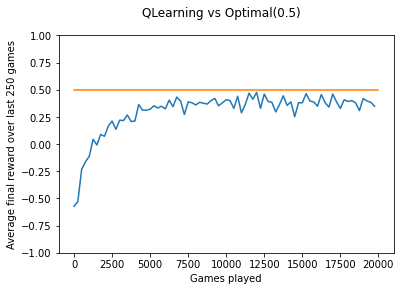

In [92]:
window_size = 250
plt.plot(windowed_avg(rewards_21, window_size))
plt.ylabel('Average final reward over last 250 games')
plt.ylim(-1, 1)
plt.xlabel('Games played')
xticks = np.arange(nb_games // window_size + 1, step=10)
plt.xticks(xticks, xticks * window_size)
plt.suptitle("QLearning vs Optimal(0.5)")
plt.plot([0, nb_games//window_size], [.5, .5])
plt.show()

### 2.1.1 Decreasing exploration

Launch games for n*= 1


  0%|          | 0/20000 [00:00<?, ?it/s]

End of games for n*= 1
Launch games for n*= 10


  0%|          | 0/20000 [00:00<?, ?it/s]

End of games for n*= 10
Launch games for n*= 100


  0%|          | 0/20000 [00:00<?, ?it/s]

End of games for n*= 100
Launch games for n*= 1000


  0%|          | 0/20000 [00:00<?, ?it/s]

End of games for n*= 1000
Launch games for n*= 10000


  0%|          | 0/20000 [00:00<?, ?it/s]

End of games for n*= 10000
Launch games for n*= 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

End of games for n*= 20000


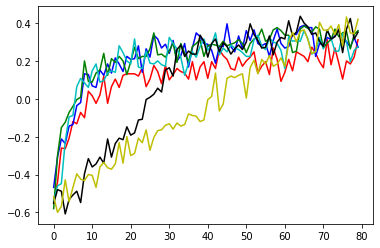

In [99]:
# Question 2
# ##########
plt.figure(figsize=(10, 6))
nb_games = 20000

# We prepare the M values for question 3.
list_Ms_plots = []
for n_star, c in zip((1, 10, 100, 1000, 10000, 20000),
                     ('r', 'b', 'g', 'c', 'k', 'y')):
    print("Launch games for n*=", n_star)

    # A Q-learner with a decreasing exploration.
    # Max exploration at the begining:
    #     epsilon_max = 80%
    # Min exploration in the end:
    #     epsilon_min = 10%
    # Number of games before reaching the minimum
    #     exploration varies, we call is n_star.
    qlplayer = QLPlayer(epsilon=decreasing_epsilon(n_star),
                        lr=0.05,
                        discount=0.99)
    semi_random_player = OptimalPlayer(0.5)

    # Collect M values every 250 games, going through 500 games.
    rewards, Ms = play_games(qlplayer,
                                semi_random_player,
                                nb_games=nb_games,
                                period_Ms=250)
    print("End of games for n*=", n_star)
    plt.plot(windowed_avg(rewards, window_size),
             label=f'$n^*=${n_star}', c=c)
    list_Ms_plots.append(Ms)

plt.figure(figsize=(10, 6))
plt.ylabel('Average final reward over 250 games for variable $\\epsilon(n)$')
plt.ylim(-1, 1)
plt.xlabel('Games played')
xticks = np.arange(nb_games // window_size + 1, step=10)
plt.xticks(xticks, xticks * window_size)
plt.suptitle("QLearning vs Optimal(0.5)")
plt.legend()
plt.show()

Text(0.5, 0.98, '$M_{opt}$ and $M_{rand}$ for Q learning')

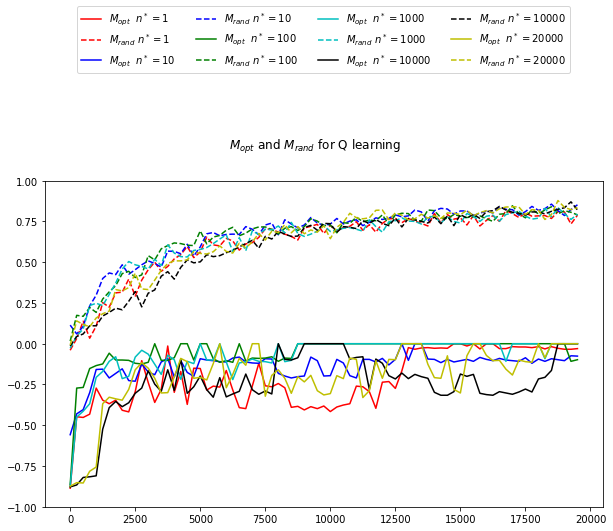

In [107]:
# Question 3
# ##########
plt.figure(figsize=(10, 6))
for Ms, c, n_star in zip(list_Ms_plots,
                         ('r', 'b', 'g', 'c', 'k', 'y'),
                         (1, 10, 100, 1000, 10000, 20000)):
    # Plot the M_opts
    plt.plot(np.arange(Ms.shape[0])*250,
             Ms[:, 0],
             c+'-',
             label='$M_{opt}$  $n^*=$' + str(n_star))
    # Plot the M_rands
    plt.plot(np.arange(Ms.shape[0])*250,
             Ms[:, 1],
             c+'--',
             label='$M_{rand}$ $n^*=$' + str(n_star))
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.55))
plt.ylim([-1, 1])
plt.suptitle("$M_{opt}$ and $M_{rand}$ for Q learning")

### 2.1.2 Good experts and bad experts

In [ ]:
# Question 4
# ##########

nb_games = 20000
chosen_nstar = 100

# We prepare the M values for question 3.
list_Ms_plots = []
for eps_opt, c in zip(.2 * np.arange(0, 6),
                      ('r', 'b', 'g', 'c', 'k', 'y')):
    print(f"Launch games against Opt(epsilon={eps_opt:.1f})")

    # A Q-learner with a decreasing exploration.
    # Max exploration at the begining:
    #     epsilon_max = 80%
    # Min exploration in the end:
    #     epsilon_min = 10%
    # Number of games before reaching the minimum
    #     exploration varies, we call is n_star.
    qlplayer = QLPlayer(epsilon=decreasing_epsilon(chosen_nstar),
                        lr=0.05,
                        discount=0.99)
    semi_random_player = OptimalPlayer(eps_opt)

    # Collect M values every 250 games, going through 500 games.
    rewards_21, Ms = play_games(qlplayer,
                                semi_random_player,
                                nb_games=nb_games,
                                period_Ms=250)
    print(f"End of games for Opt(epsilon={eps_opt:.1f})")
    plt.plot(windowed_avg(rewards_21, window_size),
             label=f'$\\epsilon=${eps_opt:.1f}', c=c)
    list_Ms_plots.append(Ms)
plt.ylabel('Average final reward over 250 games for variable $\\epsilon_{opt}$')
plt.ylim(-1, 1)
plt.xlabel('Games played')
xticks = np.arange(nb_games // window_size + 1, step=10)
plt.xticks(xticks, xticks * window_size)
plt.suptitle("QLearning vs Optimal($\\epsilon_{opt}$)")
plt.legend()
plt.show()

In [ ]:
for Ms, c, eps in zip(list_Ms_plots,
                      ('r', 'b', 'g', 'c', 'k', 'y'),
                      .1 * np.arange(0, 6)):
    legd = f"{eps:.1f}"

    # Plot the M_opts
    plt.plot(np.arange(Ms.shape[0])*250,
             Ms[:, 0],
             c+'-',
             label='$M_{opt}$  vs $\\epsilon_{opt}=$' + legd)
    # Plot the M_rands
    plt.plot(np.arange(Ms.shape[0])*250,
             Ms[:, 1],
             c+'--',
             label='$M_{rand}$ vs $\\epsilon_{opt}=$' + legd)
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.55))
plt.ylim([-1, 1])
plt.suptitle("""
    $M_{opt}$ and $M_{rand}$ for Q learning, for various $\\epsilon_{opt}$
    """)
plt.show()

In [ ]:
# Question 5
# ##########

all_Ms = np.stack(list_Ms_plots, axis=0)
print(f"Maximum value of M_opt  obtained: {np.max(all_Ms[:, :, 0])}")
print(f"Maximum value of M_rand obtained: {np.max(all_Ms[:, :, 1])}")

We'll save the results for Question 20:

In [115]:
mopt_ql_experts = list_Ms_plots[1][:, 0]
mrand_ql_experts = list_Ms_plots[1][:, 1]

## 2.2 Learning by self practice

In [116]:
def play_alone(epsilon: Callable[[int], float],
               nb_games: int = 20000
               ) -> Tuple[npt.NDArray[np.int_],
                          npt.NDArray[np.float32],
                          QLPlayer]:
    r"""
    Plays nb_games with a Q-learner against itself.

    Args:
    -----
    :param epsilon: function taking the game number as an argument:
        .. math::
            \epsilon(n) = \max\left(\epsilon_{min},
                \epsilon_{max}(1-\frac{n}{n^*})\right)

    :param nb_games: number of games to play

    :returns: array of rewards and stacked array of M_opts and M_rands
    """
    # Defines a QLearning Agent sharing a Q grid with its alter ego.
    qlplayer_1 = QLPlayer(epsilon=epsilon,
                        lr=0.05,
                        discount=0.99)
    qlplayer_2 = QLPlayer(epsilon=epsilon,
                        lr=0.05,
                        discount=0.99,
                        qvalues_ref=qlplayer_1.qvalues)

    # Play all games using the same reference for the player,
    #     and a shared reference for the Q values.
    rewards, Ms = play_games(qlplayer_1,
                             qlplayer_2,
                             nb_games=nb_games,
                             period_Ms=250,
                             learn=2)

    return rewards, Ms, qlplayer_1

In [ ]:
# Question 7
# ##########

list_Ms_plots = []
for eps, c in zip(.1 * np.arange(0, 6),
                  ('r', 'b', 'g', 'c', 'k', 'y')):
    print(f"Launch self-games # epsilon={eps:.1f}")
    rewards, Ms, _ = play_alone(constant_epsilon(eps))
    list_Ms_plots.append(Ms)
    plt.plot(windowed_avg(rewards, window_size),
             label=f'$\\epsilon=${eps:.1f}', c=c)
    print(f"End of self-games # epsilon={eps:.1f}")
plt.ylabel('Average final reward over 250 games')
plt.ylim(-1, 1)
plt.xlabel('Games played')
xticks = np.arange(nb_games // window_size + 1, step=10)
plt.xticks(xticks, xticks * window_size)
plt.suptitle(r"""QLearning vs oneself for variable exploration
    rates $\epsilon$""")
plt.legend()
plt.show()

In [ ]:
for Ms, c, eps in zip(list_Ms_plots,
                         ('r', 'b', 'g', 'c', 'k', 'y'),
                         .1 * np.arange(0, 6)):
    legd = f"{eps:.1f}"

    # Plot the M_opts
    plt.plot(np.arange(Ms.shape[0])*250,
             Ms[:, 0],
             c+'-',
             label='$M_{opt}$  $\\epsilon=$' + legd)
    # Plot the M_rands
    plt.plot(np.arange(Ms.shape[0])*250,
             Ms[:, 1],
             c+'--',
             label='$M_{rand}$ $\\epsilon=$' + legd)
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.55))
plt.ylim([-1, 1])
plt.suptitle("$M_{opt}$ and $M_{rand}$ for self-taught Q learning")
plt.show()

Launch self-games # n*=1.0


  0%|          | 0/20000 [00:00<?, ?it/s]

End of self-games # n*=1.0
Launch self-games # n*=10.0


  0%|          | 0/20000 [00:00<?, ?it/s]

End of self-games # n*=10.0
Launch self-games # n*=100.0


  0%|          | 0/20000 [00:00<?, ?it/s]

End of self-games # n*=100.0
Launch self-games # n*=1000.0


  0%|          | 0/20000 [00:00<?, ?it/s]

End of self-games # n*=1000.0
Launch self-games # n*=10000.0


  0%|          | 0/20000 [00:00<?, ?it/s]

End of self-games # n*=10000.0
Launch self-games # n*=20000.0


  0%|          | 0/20000 [00:00<?, ?it/s]

End of self-games # n*=20000.0


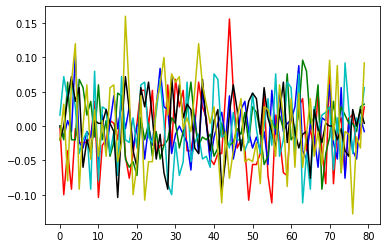

In [117]:
# Question 8
# ##########

list_Ms_plots = []
for n_star, c in zip((1, 10, 100, 1000, 10000, 20000),
                     ('r', 'b', 'g', 'c', 'k', 'y')):
    print(f"Launch self-games # n*={n_star:.1f}")
    rewards, Ms, _ = play_alone(epsilon=decreasing_epsilon(n_star=n_star))
    list_Ms_plots.append(Ms)
    plt.plot(windowed_avg(rewards, window_size),
             label=f'$n^*=${n_star:.1f}', c=c)
    print(f"End of self-games # n*={n_star:.1f}")

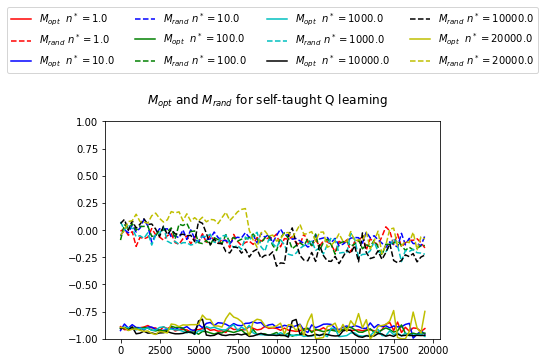

In [118]:
for Ms, c, n_star in zip(list_Ms_plots,
                         ('r', 'b', 'g', 'c', 'k', 'y'),
                         (1, 10, 100, 1000, 10000, 20000)):
    legd = f"{n_star:.1f}"

    # Plot the M_opts
    plt.plot(np.arange(Ms.shape[0])*250,
             Ms[:, 0],
             c+'-',
             label='$M_{opt}$  $n^*=$' + legd)
    # Plot the M_rands
    plt.plot(np.arange(Ms.shape[0])*250,
             Ms[:, 1],
             c+'--',
             label='$M_{rand}$ $n^*=$' + legd)
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.55))
plt.ylim([-1, 1])
plt.suptitle("$M_{opt}$ and $M_{rand}$ for self-taught Q learning")
plt.xlabel('Games played')
plt.show()

We'll save those results for Question 20:

In [122]:
mopt_ql_selfprac = list_Ms_plots[5][:, 0]
mrand_ql_selfprac = list_Ms_plots[5][:, 1]

In [ ]:
# Question 9
# ##########

all_Ms = np.stack(list_Ms_plots, axis=0)
print(f"Maximum value of M_opt  obtained: {np.max(all_Ms[:, :, 0])}")
print(f"Maximum value of M_rand obtained: {np.max(all_Ms[:, :, 1])}")

In [ ]:
# Question 10
# ###########

def get_qvals_for_state(study_state: Grid,
                        player: QLPlayer) -> Grid:
    state: int = QLPlayer.state_to_int(study_state)
    return player.get_qvalues()[state, :].reshape(3, 3)


def plot_three_choices(player: QLPlayer) -> None:
    correspondance: dict = {0: '-', 1: 'X', -1: 'O'}

    fig, axs = plt.subplots(3, 2)
    rendering_env = TictactoeEnv()

    desc1 = '''Game begins, I am X, what do I do?'''
    CHOICE1: Grid = np.zeros((3, 3), dtype=np.float64)

    desc2 = '''X started and put on the corner
        (it seems like it is not Opt(1)),\n
         I am O, what do I do?'''
    CHOICE2: Grid = np.array([[0., 0., 0.],
                              [0., 1., 0.],
                              [0., 0., 0.]], dtype=np.float64)

    desc3 = '''X started, I am 0 and I derped on turn 2
        by playing left side.\n
        So did X by playing again in the corner.\n
        Should I play in the middle?'''
    CHOICE3: Grid = np.array([[1., 0., 0.],
                              [-1., 0., 0.],
                              [0., 0., 1.]], dtype=np.float64)

    for k, desc, choice in zip(range(3),
                               (desc1, desc2, desc3),
                               (CHOICE1, CHOICE2, CHOICE3)):
        print("Scenario "+str(k+1)+":")
        print(desc)
        qvals: Grid = get_qvals_for_state(choice, player)
        rendering_env.grid = choice
        rendering_env.render()

        ax = axs[k, 0]
        ax.imshow(qvals, cmap='cool')
        ax.set_xticks([])
        ax.set_yticks([])
        for i in range(3):
            for j in range(3):
                ax.text(j, i, correspondance[choice[i, j]],
                        ha="center", va="center", color='black')

        ax = axs[k, 1]
        ax.text(.5, .5, desc, ha="center", va="center")
        ax.axis('off')

In [ ]:
_, _, good_player = play_alone(epsilon=decreasing_epsilon(n_star=int(1e5)))

In [ ]:
plot_three_choices(good_player)

# 3. Deep Q-Learning
All of the following implementations will be based on the PyTorch RL Tutorial:  
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.htmlhttps://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [8]:
from dqnplayer import DQNPlayer

We'll try to work on a GPU if one is available to PyTorch:

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Game function for DQN
We'll now write the function that wraps the whole training loop.  
First, we need two functions to manipulate states and make them coherent with the format expected by the DQN agent:

In [123]:
def measure_performances(dqn_agent):
    """
    Measures the performances (Mopt and Mrand) of Deep Q-Learning agent.
    """
    # Deactivates the epsilon policy
    epsilon = dqn_agent.epsilon
    dqn_agent.epsilon = constant_epsilon(0)
    
    # MOPT
    optimal_player = OptimalPlayer(0)
    rewards, _ = play_games_dqn(dqn_agent, optimal_player, nb_games=500, turns_swap="half", learn="none", show_progress_bar=False)
    m_opt = rewards.sum() / 500
    
    # MRAND
    random_player = OptimalPlayer(1)
    rewards, _ = play_games_dqn(dqn_agent, random_player, nb_games=500, turns_swap="half", learn="none", show_progress_bar=False)
    m_rand = rewards.sum() / 500
    
    # Reactivates the epsilon policy
    dqn_agent.epsilon = epsilon
    return m_opt, m_rand

In [124]:
def grid33_to_332(grid, player, player2value):
    """
    Converts a grid in 3x3 shape whose values are -1, 0 and 1
    to the format expected by the DQN player, as a 3x3x2 array.
    --player: either 'X' or 'O', which player the DQN agent is.
    --player2value: player (X or O) to index (-1 or 1) association,
        obtained from the environment.
    """
    grid_332 = np.zeros((3, 3, 2))
    # Get the value in the original grid corresponding to the player
    # played by the dqn agent:
    player_ind = player2value[player]

    grid_332[grid == player_ind, 0] = 1
    grid_332[grid == -player_ind, 1] = 1
    return grid_332


def grid_to_tensor(grid, player, env):
    """
    Converts the numpy array grid returned by the environment to a torch
    tensor in the format expected by the DQN agent.
    """
    grid_tensor = grid33_to_332(grid, player, env.player2value)
    grid_tensor = torch.tensor(grid_tensor, device=device).unsqueeze(0).float()
    return grid_tensor

We can now write the training loop:

In [125]:
def play_games_dqn(dqn_player, benchmark_player, nb_games=20000,
                   games_between_updates=500,
                   turns_swap="switch",
                   learn="first",
                   measure_perf=False,
                   show_progress_bar=True):
    """
    Plays a given number of games between two players, and returns the rewards.
    --dqn_player: Instance of DQNPlayer to train;
    --benchmark_player: Player object implementing act();
    --nb_games: How many games should be played;
    --games_between_updates: how many games are played between two updates of the agent's
        target network.
    --turns_swap: Either 'switch' or 'half', method to swap turns at the start of each game.
        'half' means that the starting turns will switch after half the games have been played out.
    --learn: "first", "none" or "both", designs which player learn during the games. "first" means only
        the first player learns, "none" means none of the two does, "both" means both agents learn.
    --measure_perf: if True, the function will additionnally return the list of performances (mopt mrand)
        measured every 250 training games.
    --show_progress_bar: boolean, whether to show the progress live using tqdm.
    Returns two arrays: rewards, losses [, (mopt, mrand) ]
    """
    rewards, losses = [], []
    env = TictactoeEnv()
    m_opt_values, m_rand_values = [], []
    
    if show_progress_bar:
        games_iterator = trange(nb_games)
    else:
        games_iterator = range(nb_games)

    for game in games_iterator:
        # Sets up the environment for the game
        env.reset()
        grid, _, _ = env.observe()

        if turns_swap == "switch":
            dqn_player.set_player(j=game)
            benchmark_player.set_player(j=game + 1)
        elif turns_swap == "half":
            dqn_player.set_player(j=int(game < nb_games / 2))
            benchmark_player.set_player(j=int(game >= nb_games / 2))

        # Convert the grid from the env's format to that expected by the agent
        grid_tensor = grid_to_tensor(grid, dqn_player.player, env)
        game_losses = []

        while True:
            # Action step
            # We now need to account for the case where the agent chooses
            # an unavailable position.
            try:
                if env.current_player == dqn_player.player:
                    move = dqn_player.act(grid_tensor, game)
                else:
                    move = benchmark_player.act(grid)

                grid, end, winner = env.step(move, print_grid=False)
                grid_tensor = grid_to_tensor(grid, dqn_player.player, env)
                reward = env.reward(dqn_player.player)

            except ValueError:
                # Being here means the agent chose an impossible action
                # Stop the game and set the reward for the agent to -1
                end = True
                reward = -1

            # Learning step
            # The DQN agent must have played at least once to start learning
            if learn in ['first', 'both'] and (env.current_player == dqn_player.player or end):
                # For the DQN agent, final states will be represented as None
                if end:
                    grid_tensor = None
                game_losses.append(dqn_player.learn(torch.tensor([reward], device=device),
                                               grid_tensor))

            if end:
                losses.append(np.mean(game_losses))
                rewards.append(reward)
                break

        # Update the agent's target network if required
        if learn in ['first', 'both'] and game % games_between_updates == 0:
            dqn_player.update()
       
        # Potential performances measurement
        if measure_perf and (game + 1) % 250 == 0:
            m_opt, m_rand = measure_performances(dqn_player)
            m_opt_values.append(m_opt)
            m_rand_values.append(m_rand)

    if measure_perf:
        return np.array(rewards), np.array(losses), np.array(m_opt_values), np.array(m_rand_values)
    else:
        return np.array(rewards), np.array(losses)

## 3.2 Learning from experts

### Question 11

In [101]:
semi_opt_player = OptimalPlayer(0.5)
dqn_player = DQNPlayer(device, epsilon=constant_epsilon(0.05))

# Trains the DQN Agent by playing a semi-optimal player
nb_games = 20000
rewards, losses = play_games_dqn(dqn_player, semi_opt_player, nb_games=nb_games)

  0%|          | 0/20000 [00:00<?, ?it/s]

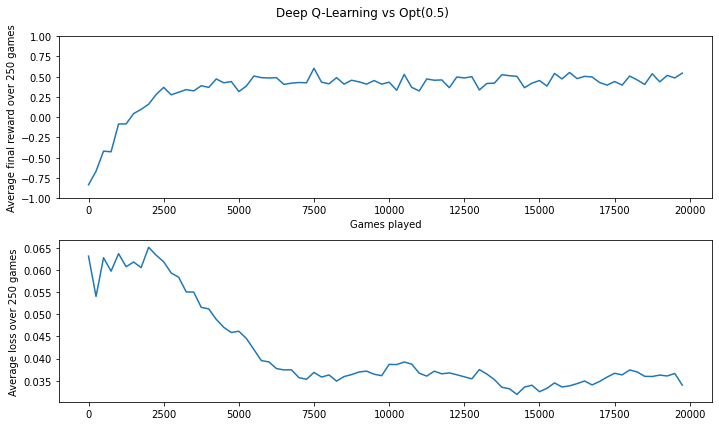

In [102]:
window_size = 250
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.suptitle("Deep Q-Learning vs Opt(0.5)")
ax[0].plot(windowed_avg(rewards, window_size))
ax[0].set_ylabel('Average final reward over 250 games')
ax[0].set_ylim(-1, 1)
xticks = np.arange(nb_games // window_size + 1, step=10)
labels = [str(k) for k in xticks * window_size]
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(labels)
ax[0].set_xlabel('Games played')

# Plots average game losses
ax[1].plot(windowed_avg(losses, window_size))
ax[1].set_ylabel('Average loss over 250 games')
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(labels)
plt.tight_layout()
plt.show()

### Question 12

In [16]:
semi_opt_player = OptimalPlayer(0.5)
dqn_player = DQNPlayer(device, epsilon=constant_epsilon(0.05), use_replay=False)

# Trains the DQN Agent by playing a semi-optimal player
nb_games = 20000
rewards, losses = play_games_dqn(dqn_player, semi_opt_player, nb_games=nb_games)

  0%|          | 0/20000 [00:00<?, ?it/s]

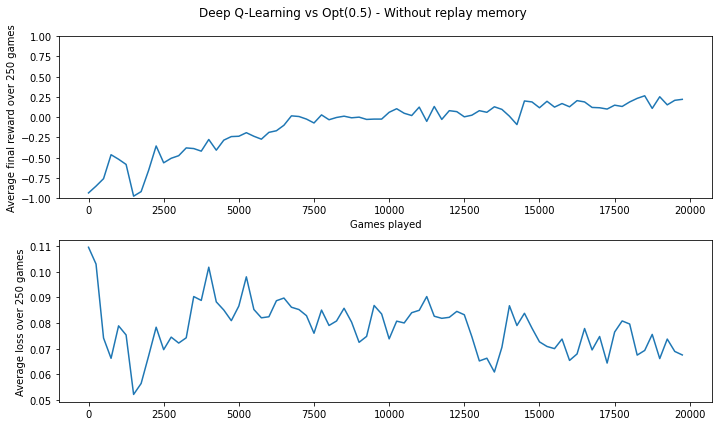

In [17]:
window_size = 250
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.suptitle("Deep Q-Learning vs Opt(0.5) - Without replay memory")
ax[0].plot(windowed_avg(rewards, window_size))
ax[0].set_ylabel('Average final reward over 250 games')
ax[0].set_ylim(-1, 1)
xticks = np.arange(nb_games // window_size + 1, step=10)
labels = [str(k) for k in xticks * window_size]
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(labels)
ax[0].set_xlabel('Games played')

# Plots average game losses
ax[1].plot(windowed_avg(losses, window_size))
ax[1].set_ylabel('Average loss over 250 games')
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(labels)
plt.tight_layout()
plt.show()show_progress_bar

### Question 13

In [ ]:
n_star_values = [1, 10, 100, 1000, 10000, 20000]
# Dict that will associate every value of n* to its performances curve
perfs = []
game_indices = np.arange(0, 20001, 250)
for n_star in n_star_values:
    dqn_player = DQNPlayer(device, epsilon=decreasing_epsilon(n_star))
    semi_random_player = OptimalPlayer(0.5)

    # Trains for 20,0000 games and measure the performances every 250 games
    _, _, m_opt_values, m_rand_values = play_games_dqn(dqn_player, semi_random_player,
                                                       nb_games=20000,
                                                       measure_perf=True)
    # For each performance measure, adds an entry in the list with
    # (value of n*, number of games played at the time of measurement, measured Mopt, Mrand)
    for n_games, m_opt, m_rand in zip(game_indices, m_opt_values, m_rand_values):
        perfs.append((n_star, n_games, m_opt, m_rand))

# Converts the performances list to a DataFrame
perfs_df = pd.DataFrame(perfs, columns=['n_star', 'training games', 'M_opt', 'M_rand'])

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
fig.suptitle("Comparison of $n*$ against Opt(0.5)")
sns.lineplot(data=perfs_df, x="training games", y="M_opt", hue="n_star", style="n_star", ax=ax[0],
             palette=sns.color_palette("husl", len(n_star_values)))
ax[0].set_ylabel("$M_{opt}$")
ax[0].set_xlabel("Training games completed")
sns.lineplot(data=perfs_df, x="training games", y="M_rand", hue="n_star", style="n_star", ax=ax[1],
             palette=sns.color_palette("husl", len(n_star_values)))
ax[1].set_ylabel("$M_{rand}$")
ax[1].set_xlabel("Training games completed")

In [131]:
best_nstar = 10

### Question 14

In [144]:
opponent_eps_values = [0, 0.01, 0.05, 0.1, 0.5, 1]

In [145]:
perfs = []
for eps in opponent_eps_values:
    dqn_player = DQNPlayer(device, epsilon=decreasing_epsilon(best_nstar))
    opponent = OptimalPlayer(eps)
    # Trains for 20,0000 games and measure the performances every 250 games
    _, _, m_opt_values, m_rand_values = play_games_dqn(dqn_player, opponent,
                                                       nb_games=20000,
                                                       measure_perf=True)
    # For each performance measure, adds an entry in the list with
    # (value of epsilon, number of games played at the time of measurement, measured Mopt, Mrand)
    for n_games, m_opt, m_rand in zip(game_indices, m_opt_values, m_rand_values):
        perfs.append((eps, n_games, m_opt, m_rand))

# Converts the performances list to a DataFrame
perfs_df = pd.DataFrame(perfs, columns=['epsilon', 'training games', 'M_opt', 'M_rand'])

  0%|          | 0/20000 [00:00<?, ?it/s]

/home/clement/.conda/envs/torch-gpu/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/clement/.conda/envs/torch-gpu/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [150]:
perfs_df.to_csv('question14_df.csv')

Text(0.5, 0, 'Training games completed')

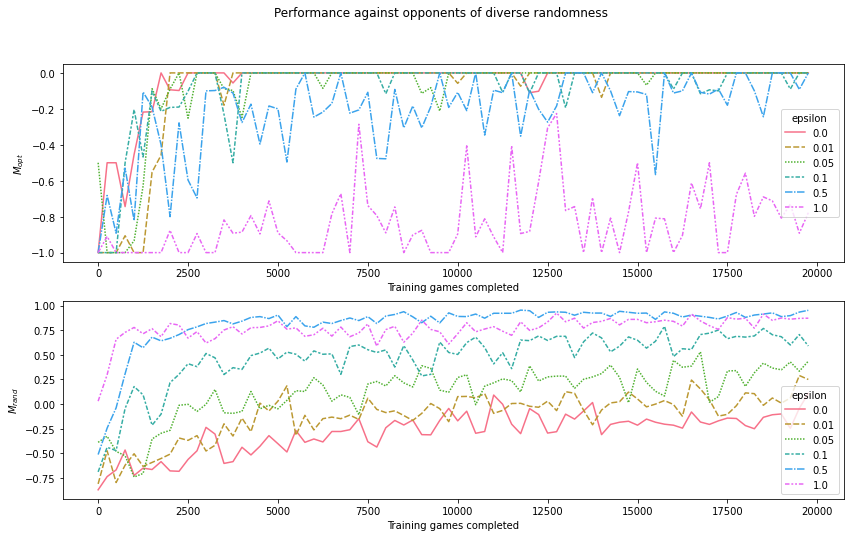

In [151]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
fig.suptitle("Performance against opponents of diverse randomness")
sns.lineplot(data=perfs_df, x="training games", y="M_opt", hue="epsilon", style="epsilon", ax=ax[0],
             palette=sns.color_palette("husl", len(opponent_eps_values)))
ax[0].set_ylabel("$M_{opt}$")
ax[0].set_xlabel("Training games completed")
sns.lineplot(data=perfs_df, x="training games", y="M_rand", hue="epsilon", style="epsilon", ax=ax[1],
             palette=sns.color_palette("husl", len(opponent_eps_values)))
ax[1].set_ylabel("$M_{rand}$")
ax[1].set_xlabel("Training games completed")

We'll save those results for Question 20:

In [156]:
mopt_dqn_experts = perfs_df[perfs_df['epsilon'] == 0]['M_opt'].iloc[1:]
mrand_dqn_experts = perfs_df[perfs_df['epsilon'] == 0.5]['M_rand'].iloc[1:]

### Question 15

* The best value of $M_{opt}$ reached is clearly 0.

In [158]:
print("Best M_rand: ")
print(perfs_df[perfs_df['M_rand'] == perfs_df['M_rand'].max()])

Best M_rand: 
     epsilon  training games  M_opt  M_rand
367      0.5           11750 -0.352   0.954


## 3.3 Learning by self-practice

### Game function for self-practice DQN

In [17]:
def play_games_dqn_self_practice(dqn_player_1, dqn_player_2, nb_games=20000,
                               games_between_updates=500,
                               turns_swap="switch",
                               measure_perf=False,
                               show_progress_bar=True):
    """
    Plays a given number of games between two dqn agents, and returns the rewards and losses.
    --dqn_player: Instance of DQNPlayer to train;
    --dqn_player_2: Second DQNPlayer.
    --nb_games: How many games should be played;
    --games_between_updates: how many games are played between two updates of the agent's
        target network.
    --turns_swap: Either 'switch' or 'half', method to swap turns at the start of each game.
        'half' means that the starting turns will switch after half the games have been played out.
    --measure_perf: if True, the function will additionnally return the list of performances (mopt mrand)
        measured every 250 training games, for the first DQN Agent.
    --progress_bar: boolean, whether to show live progress using tqdm.
    Returns two arrays: rewards, losses [, (mopt, mrand) ]
    """
    rewards, losses = [], []
    env = TictactoeEnv()
    m_opt_values, m_rand_values = [], []

    if show_progress_bar:
        games_iterator = trange(nb_games)
    else:
        games_iterator = range(nb_games)
        
    for game in games_iterator:
        # Sets up the environment for the game
        env.reset()
        grid, _, _ = env.observe()

        if turns_swap == "switch":
            dqn_player_1.set_player(j=game)
            dqn_player_2.set_player(j=game + 1)
        elif turns_swap == "half":
            dqn_player_1.set_player(j=int(game < nb_games / 2))
            dqn_player_2.set_player(j=int(game >= nb_games / 2))
        
        players = {dqn_player_1.player: dqn_player_1,
                   dqn_player_2.player: dqn_player_2}

        # Convert the grid from the env's format to that expected by the agent
        grid_tensor = grid_to_tensor(grid, env.current_player, env)
        game_losses = []

        while True:
            # Retrieves the right player for the current move
            current_player = players[env.current_player]
            # Action step
            # We now need to account for the case where the agent chooses
            # an unavailable position.
            try:
                move = current_player.act(grid_tensor, game)

                grid, end, winner = env.step(move, print_grid=False)
                grid_tensor = grid_to_tensor(grid, env.current_player, env)
                reward = env.reward(current_player.player)

            except ValueError:
                # Being here means the agent chose an impossible action
                # Stop the game and set the reward for the agent to -1
                end = True
                reward = -1

            # Learning step
            # Final states will be represented as None
            if end:
                grid_tensor = None
            loss = current_player.learn(torch.tensor([reward], device=device), grid_tensor)
            if loss is not None:
                # The loss is None when the second agent is learning
                game_losses.append(loss)

            if end:
                losses.append(np.mean(game_losses))
                rewards.append(env.reward(dqn_player_1))
                break

        # Update the first agent's target network if required
        if game % games_between_updates == 0:
            dqn_player_1.update()
       
        # Potential performances measurement
        if measure_perf and (game + 1) % 250 == 0:
            m_opt, m_rand = measure_performances(dqn_player_1)
            m_opt_values.append(m_opt)
            m_rand_values.append(m_rand)

    if measure_perf:
        return np.array(rewards), np.array(losses), np.array(m_opt_values), np.array(m_rand_values)
    else:
        return np.array(rewards), np.array(losses)

### Question 16

In [159]:
epsilon_values = [0.001, 0.01, 0.05, 0.1, 0.5]

In [ ]:
perfs_q16 = []
for eps in epsilon_values:
    dqn_player_1 = DQNPlayer(device, epsilon=constant_epsilon(eps))
    dqn_player_2 = DQNPlayer(device, epsilon=constant_epsilon(eps), use_agent_weights=dqn_player_1)
    
    # Trains for 20,0000 games and measure the performances every 250 games
    _, _, m_opt_values, m_rand_values = play_games_dqn_self_practice(dqn_player_1, dqn_player_2,
                                                       nb_games=20000,
                                                       measure_perf=True)
    # For each performance measure, adds an entry in the list with
    # (value of epsilon, number of games played at the time of measurement, measured Mopt, Mrand)
    for n_games, m_opt, m_rand in zip(game_indices, m_opt_values, m_rand_values):
        perfs_q16.append((eps, n_games, m_opt, m_rand))

# Converts the performances list to a DataFrame
perfs_q16 = pd.DataFrame(perfs, columns=['epsilon', 'training games', 'M_opt', 'M_rand'])

  0%|          | 0/20000 [00:00<?, ?it/s]

/home/clement/.conda/envs/torch-gpu/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/clement/.conda/envs/torch-gpu/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
fig.suptitle("Deep Q-Learning self-practice with varying constant epsilon")
sns.lineplot(data=perfs_q16, x="training games", y="M_opt", hue="epsilon", style="epsilon", ax=ax[0],
             palette=sns.color_palette("husl", len(opponent_eps_values)))
ax[0].set_ylabel("$M_{opt}$")
ax[0].set_xlabel("Training games completed")
sns.lineplot(data=perfs_q16, x="training games", y="M_rand", hue="epsilon", style="epsilon", ax=ax[1],
             palette=sns.color_palette("husl", len(opponent_eps_values)))
ax[1].set_ylabel("$M_{rand}$")
ax[1].set_xlabel("Training games completed")

### Question 17

In [ ]:
n_star_values = [1, 10, 100, 1000, 10000]
# Dict that will associate every value of n* to its performances curve
perfs_q17 = []
game_indices = np.arange(0, 20001, 250)
dqn_agents_sp = {}
for n_star in n_star_values:
    dqn_player_1 = DQNPlayer(device, epsilon=decreasing_epsilon(n_star))
    dqn_player_2 = DQNPlayer(device, epsilon=decreasing_epsilon(n_star), use_agent_weights=dqn_player_1)
    dqn_agents_sp[n_star] = (dqn_player_1, dqn_player_2)

    # Trains for 20,0000 games and measure the performances every 250 games
    _, _, m_opt_values, m_rand_values = play_games_dqn_self_practice(dqn_player_1, dqn_player_2,
                                                       nb_games=20000,
                                                       measure_perf=True)
    # For each performance measure, adds an entry in the list with
    # (value of n*, number of games played at the time of measurement, measured Mopt, Mrand)
    for n_games, m_opt, m_rand in zip(game_indices, m_opt_values, m_rand_values):
        perfs_q17.append((n_star, n_games, m_opt, m_rand))

# Converts the performances list to a DataFrame
perfs_q17 = pd.DataFrame(perfs, columns=['n_star', 'training games', 'M_opt', 'M_rand'])

Text(0.5, 0, 'Training games completed')

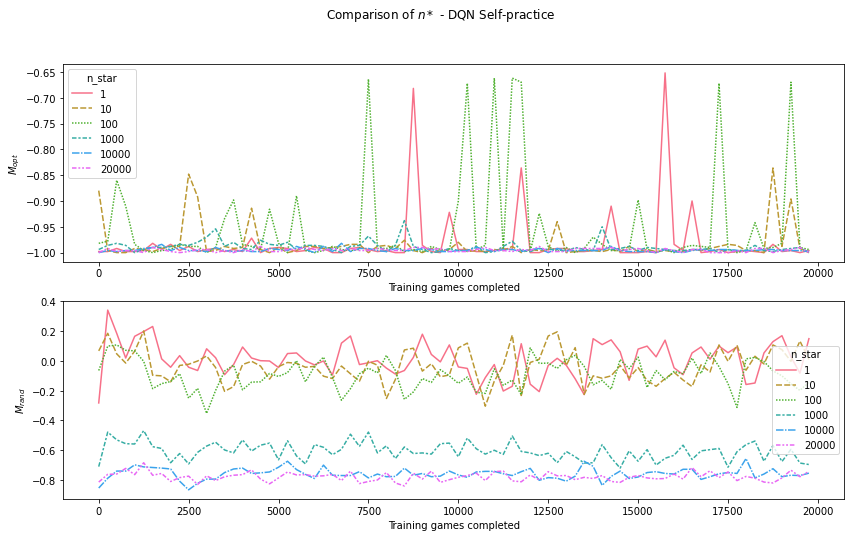

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
fig.suptitle("Comparison of $n*$ - DQN Self-practice")
sns.lineplot(data=perfs_q17, x="training games", y="M_opt", hue="n_star", style="n_star", ax=ax[0],
             palette=sns.color_palette("husl", len(n_star_values)))
ax[0].set_ylabel("$M_{opt}$")
ax[0].set_xlabel("Training games completed")
sns.lineplot(data=perfs_q17, x="training games", y="M_rand", hue="n_star", style="n_star", ax=ax[1],
             palette=sns.color_palette("husl", len(n_star_values)))
ax[1].set_ylabel("$M_{rand}$")
ax[1].set_xlabel("Training games completed")

We'll save those results for Question 20:

### Question 18

In [23]:
print("Best M_opt: ", perfs_df[perfs_df['M_opt'] == perfs_df['M_opt'].max()])

Best M_opt:      n_star  training games  M_opt  M_rand
63       1           15750 -0.652    0.14


In [24]:
print("Best M_rand: \n", perfs_df[perfs_df['M_rand'] == perfs_dbest_nstar_selfpracticed'].max()])

Best M_rand:     n_star  training games  M_opt  M_rand
1       1             250 -0.998   0.342


In [27]:
best_nstar_selfpractice = 10
best_dqn_agent_sp = dqn_agents_sp[best_nstar_selfpractice]

### Question 19

In [84]:
choices = [
    np.array([[1, 0, 0],
              [-1, 0, 1],
              [-1, 0, 1]]),
    np.array([[-1, 0, 0],
              [1, 0, -1],
              [1, 0, -1]]),
    np.zeros((3, 3))
]
choices = [arr.astype(int) for arr in choices]

players = ['X', 'X', 'X']

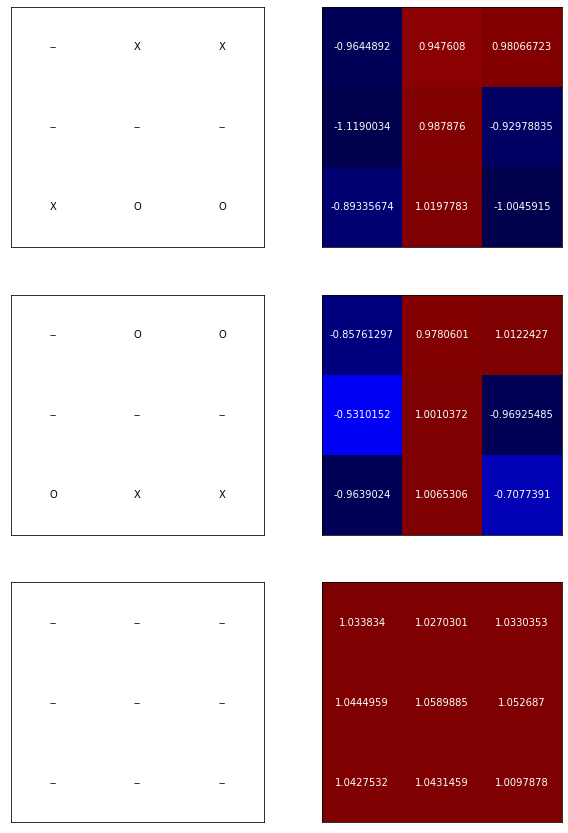

In [86]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
env = TictactoeEnv()
cmap_norm = Normalize(vmin=-1, vmax=1)
val2player = ['--', 'X', 'O']

for k, (choice, player) in enumerate(zip(choices, players)):
    # For each choice, compute the qvalues
    state = grid_to_tensor(choice, 'X', env)
    qvalues = best_dqn_agent_sp.get_qvalues(state).reshape((3, 3))
    ax[k, 1].imshow(qvalues, cmap="seismic", norm=cmap_norm)
    
    for pos in range(9):
        i, j = pos // 3, pos % 3
        # Displays the Qvalues for the given position
        ax[k, 1].text(j, i, str(qvalues[i, j]), ha='center',va='center', color="white")
        ax[k, 1].set_xticks([])
        ax[k, 1].set_yticks([])
        
        # Draws the position
        ax[k, 0].text(i, j, val2player[choice[i, j]], ha='center', va='center')
        ax[k, 0].set_ylim((-0.5, 2.5))
        ax[k, 0].set_xlim((-0.5, 2.5))
        ax[k, 0].set_xticks([])
        ax[k, 0].set_yticks([])

## 4 Comparing Q-Learning with Deep Q-Learning

### Question 20